# Lactate Carbon Fraction 

**Goals:**
1. Find the optimal lactate carbon percentage for maximum butyrate production
2. Find the optimal lactate carbon percentage for maximum Eubacterium biomass growth
3. Plot butyrate/biomass ratio vs lactate carbon fraction

In [1]:
%reset -f

import os
# COMETS and Gurobi paths (macOS)
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

In [2]:
import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
VOL = 1e-3                         # cm³  
SPACE_WIDTH = VOL ** (1/3)         # 0.1 cm
BOX_VOL_CM3 = SPACE_WIDTH ** 3     # cm³
BOX_VOL_L  = BOX_VOL_CM3 * 1e-3  # 1 cm³ = 1 mL 

def mM_to_mmol(conc_mM):
    'concentration to mmol'
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    'mmol to concentration'
    return amount_mmol / BOX_VOL_L

# Parameters
DEFAULT_VMAX = 10.0      
DEFAULT_KM   = 5e-4       # mmol/cm3
DEFAULT_HILL  = 1
TIME_STEP  = 0.01         
MAX_CYCLES = 300          
LOG_RATE   = 1

INIT_BIOMASS = 5e-7        # g 
MAX_SPACE_BIOMASS = 1e-3   # g
MIN_SPACE_BIOMASS = 1e-14  # g


#conecentation & amounts
GLC_MAX_mM   = 10.0      # max glucose concentration 
NH4_CONC_mM  = 5.0       # ammonium
ION_CONC_mM  = 5.0       # major ions
AA_CONC_mM   = 2.0       # amino acids
TRACE_CONC_mM = 0.1      # trace metals & vitamins
WATER_AMOUNT  = 1e-4     # mmol 

#media 
water_proton_ids = {'h2o[e]'}
major_ion_ids    = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids  = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids      = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids           = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]',
                    'met_L[e]', 'glycys[e]', 'glyglu[e]'}

background_met_ids = water_proton_ids | major_ion_ids | trace_metal_ids | vitamin_ids | aa_ids | {'nh4[e]'}

print(f'10 mM glucose → {mM_to_mmol(10.0):.2e} mmol in box')

10 mM glucose → 1.00e-05 mmol in box


In [4]:
model_1 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')

# exchanges by default
for rxn in model_1.exchanges:
    rxn.lower_bound = 0.0
    rxn.upper_bound = 1000.0

# metabolite-to-exchange mapping
met_to_ex = {
    met.id: rxn.id
    for rxn in model_1.exchanges
    for met in rxn.metabolites
    if met.compartment == 'e'
}
all_ex_mets = set(met_to_ex.keys())
print(f'Eubacterium exchange metabolites: {len(all_ex_mets)}')


def classify_and_set_media(layout, ex_mets):

    for met in ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    # Set background metabolites by category
    for met in ex_mets:
        if met in water_proton_ids:
            layout.set_specific_metabolite(met, WATER_AMOUNT)
            layout.set_specific_static(met, WATER_AMOUNT)
        elif met in major_ion_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(ION_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(ION_CONC_mM))
        elif met in trace_metal_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in vitamin_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in aa_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(AA_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(AA_CONC_mM))
        elif met == 'nh4[e]':
            layout.set_specific_metabolite(met, mM_to_mmol(NH4_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(NH4_CONC_mM))


def make_params():

    params = c.params()
    params.set_param('spaceWidth',       SPACE_WIDTH)
    params.set_param('defaultVmax',      DEFAULT_VMAX)
    params.set_param('defaultKm',        DEFAULT_KM)
    params.set_param('defaultHill',      DEFAULT_HILL)
    params.set_param('exchangestyle',    'Monod Style')
    params.set_param('timeStep',         TIME_STEP)
    params.set_param('maxCycles',        MAX_CYCLES)
    params.set_param('maxSpaceBiomass',  MAX_SPACE_BIOMASS)
    params.set_param('minSpaceBiomass',  MIN_SPACE_BIOMASS)
    params.set_param('writeMediaLog',    True)
    params.set_param('MediaLogRate',     LOG_RATE)
    params.set_param('writeFluxLog',     True)
    params.set_param('FluxLogRate',      LOG_RATE)
    params.set_param('writeBiomassLog',  True)
    params.set_param('BiomassLogRate',   LOG_RATE)
    return params


def clean_non_ex(comets_model):
    'COMETS bug fix'
    ex_mask = comets_model.reactions['EXCH'].isin([True, 'True'])
    for name in comets_model.reactions.loc[ex_mask, 'REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


Eubacterium exchange metabolites: 119


Sweep from glucose to high lactate keeping total carbon constant at 60:

In [5]:
glucose_mM_values = np.linspace(10.0, 2.0, 21)      # mM
lactate_mM_values = np.linspace(0.0, 16.0, 21)      # mM

print(f'Glucose: {mM_to_mmol(glucose_mM_values[0]):.2e} → {mM_to_mmol(glucose_mM_values[-1]):.2e} mmol')
print(f'Lactate: {mM_to_mmol(lactate_mM_values[0]):.2e} → {mM_to_mmol(lactate_mM_values[-1]):.2e} mmol')

Glucose: 1.00e-05 → 2.00e-06 mmol
Lactate: 0.00e+00 → 1.60e-05 mmol


In [6]:
def run_simulation(glc_mM, lac_mM):

    model_copy = model_1.copy()
    model_copy.id = 'Eubacterium'

    comets_model = c.model(model_copy)
    comets_model.obj_style = 'MAXIMIZE_OBJECTIVE_FLUX'
    comets_model.open_exchanges()
    clean_non_ex(comets_model)

    comets_model.initial_pop = [0, 0, INIT_BIOMASS]

    # Layout
    layout = c.layout([comets_model])
    layout.grid = [1, 1]

    # media (ions, trace metals, vitamins, AAs, NH4)
    classify_and_set_media(layout, all_ex_mets)

    # carbon sources 
    layout.set_specific_metabolite('glc_D[e]', mM_to_mmol(glc_mM))
    layout.set_specific_refresh('glc_D[e]', 0.0)

    if lac_mM > 0.0:
        layout.set_specific_metabolite('lac_L[e]', mM_to_mmol(lac_mM))
        layout.set_specific_refresh('lac_L[e]', 0.0)

    # Params 
    params = make_params()

    sim = c.comets(layout, params)
    sim.run()

    return sim

In [7]:
# Simulation

simulations = {}

for glc_mM, lac_mM in zip(glucose_mM_values, lactate_mM_values):
    print(f'Running glc={glc_mM:6.2f} mM, lac={lac_mM:6.2f} mM  '
          f'(glc={mM_to_mmol(glc_mM):.2e}, lac={mM_to_mmol(lac_mM):.2e} mmol)')
    simulations[(glc_mM, lac_mM)] = run_simulation(glc_mM, lac_mM)


Running glc= 10.00 mM, lac=  0.00 mM  (glc=1.00e-05, lac=0.00e+00 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  9.60 mM, lac=  0.80 mM  (glc=9.60e-06, lac=8.00e-07 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  9.20 mM, lac=  1.60 mM  (glc=9.20e-06, lac=1.60e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  8.80 mM, lac=  2.40 mM  (glc=8.80e-06, lac=2.40e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  8.40 mM, lac=  3.20 mM  (glc=8.40e-06, lac=3.20e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  8.00 mM, lac=  4.00 mM  (glc=8.00e-06, lac=4.00e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  7.60 mM, lac=  4.80 mM  (glc=7.60e-06, lac=4.80e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!
Running glc=  7.20 mM, lac=  5.60 mM  (glc=7.20e-06, lac=5.60e-06 mmol)

Running COMETS simulation ...

Debug Here ...
Done!


In [10]:
data = {}

for (glc_mM, lac_mM), sim in simulations.items():
    media = sim.get_metabolite_time_series()
    time = np.arange(len(media)) * TIME_STEP

    biomass = sim.total_biomass['Eubacterium'].values

    # Extract metabolite amounts a
    glucose  = media['glc_D[e]'].values / BOX_VOL_L if 'glc_D[e]' in media.columns else None
    lactate  = media['lac_L[e]'].values / BOX_VOL_L if 'lac_L[e]' in media.columns else None
    butyrate = media['but[e]'].values / BOX_VOL_L   if 'but[e]'   in media.columns else None

    butyrate_mmol = media['but[e]'].values if 'but[e]' in media.columns else None

    data[(glc_mM, lac_mM)] = {
        'time': time,
        'biomass': biomass,
        'glucose_mM': glucose,
        'lactate_mM': lactate,
        'butyrate_mM': butyrate,
        'butyrate_mmol': butyrate_mmol,
    }

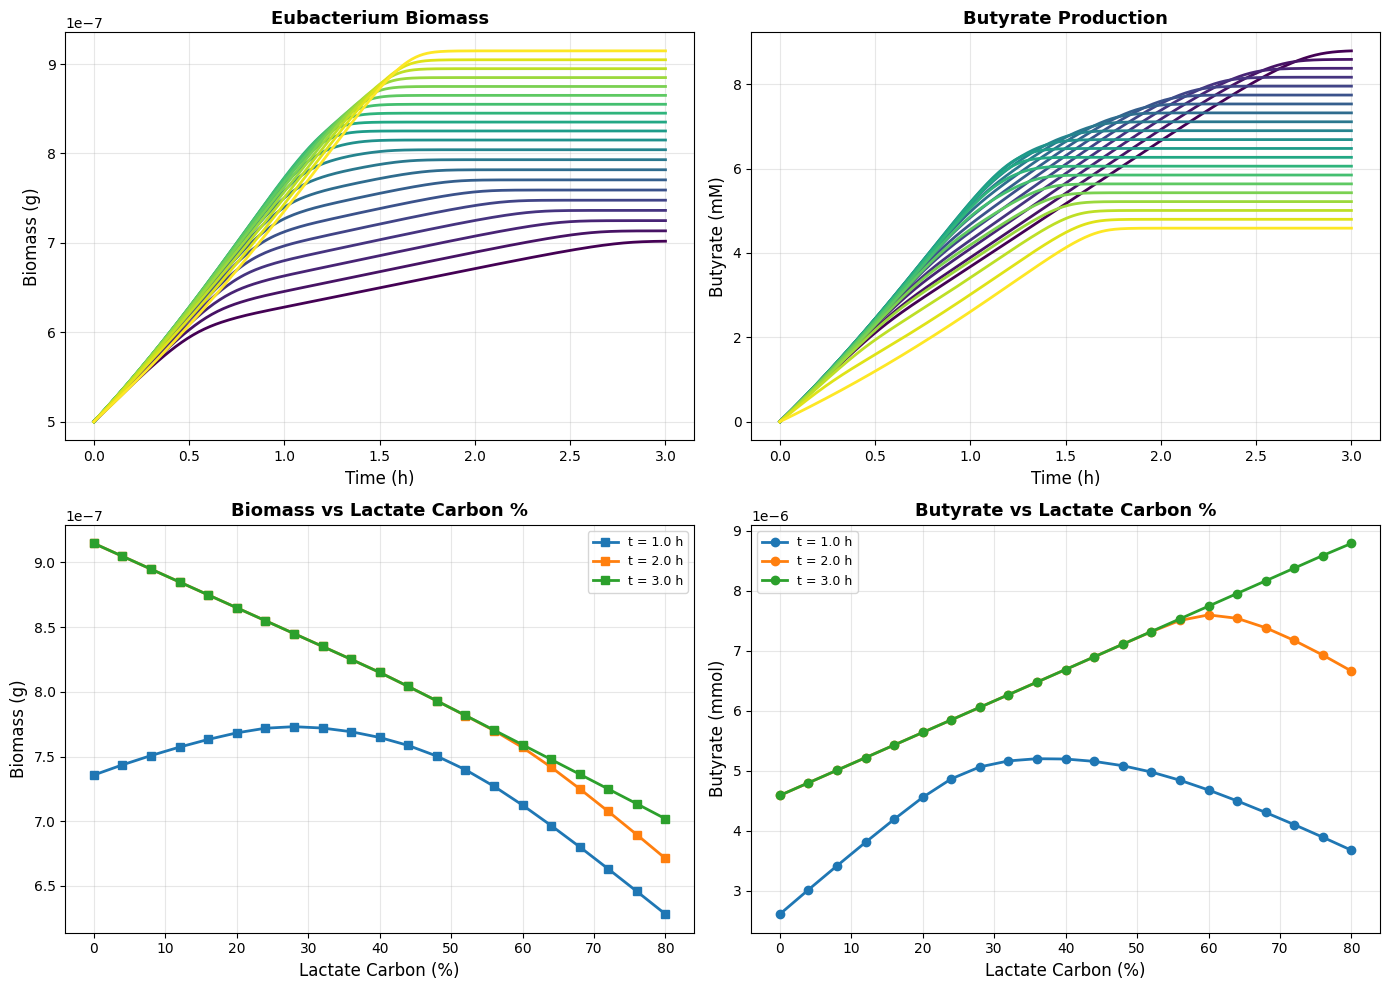

In [11]:
keys = sorted(simulations.keys())
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(keys)))
cycles = [100, 200, 300]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#  Eubacterium biomass 
ax = axes[0, 0]
for (glc_mM, lac_mM), col in zip(keys, colors):
    d = data[(glc_mM, lac_mM)]
    ax.plot(d['time'], d['biomass'], color=col, lw=2, label=f'glc={glc_mM:g}, lac={lac_mM:g}')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (g)', fontsize=12)
ax.set_title('Eubacterium Biomass', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Butyrate production 
ax = axes[0, 1]
for (glc_mM, lac_mM), col in zip(keys, colors):
    d = data[(glc_mM, lac_mM)]
    ax.plot(d['time'], d['butyrate_mM'], color=col, lw=2, label=f'glc={glc_mM:g}, lac={lac_mM:g}')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate (mM)', fontsize=12)
ax.set_title('Butyrate Production', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

#  Biomass vs lactate carbon 
ax = axes[1, 0]
lacC_pct_list = []
biomass_at_cycle = {cyc: [] for cyc in cycles}

for (glc_mM, lac_mM), sim in sorted(simulations.items()):
    denomC = 6 * glc_mM + 3 * lac_mM
    lacC_pct = 100.0 * (3 * lac_mM / denomC) if denomC > 0 else np.nan
    lacC_pct_list.append(lacC_pct)
    b = sim.total_biomass['Eubacterium'].values
    for cyc in cycles:
        biomass_at_cycle[cyc].append(b[cyc] if cyc < len(b) else np.nan)

for cyc in cycles:
    t_hr = cyc * TIME_STEP
    ax.plot(lacC_pct_list, biomass_at_cycle[cyc], 's-', lw=2, label=f't = {t_hr:.1f} h')
ax.set_xlabel('Lactate Carbon (%)', fontsize=12)
ax.set_ylabel('Biomass (g)', fontsize=12)
ax.set_title('Biomass vs Lactate Carbon %', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Butyrate vs lactate carbon 
ax = axes[1, 1]
lacC_pct_list2 = []
but_at_cycle = {cyc: [] for cyc in cycles}

for (glc_mM, lac_mM), sim in sorted(simulations.items()):
    media = sim.get_metabolite_time_series()
    denomC = 6 * glc_mM + 3 * lac_mM
    lacC_pct = 100.0 * (3 * lac_mM / denomC) if denomC > 0 else np.nan
    lacC_pct_list2.append(lacC_pct)
    but_series = media['but[e]'].values if 'but[e]' in media.columns else None
    for cyc in cycles:
        if but_series is not None and cyc < len(but_series):
            but_at_cycle[cyc].append(but_series[cyc])
        else:
            but_at_cycle[cyc].append(np.nan)

for cyc in cycles:
    t_hr = cyc * TIME_STEP
    ax.plot(lacC_pct_list2, but_at_cycle[cyc], 'o-', lw=2, label=f't = {t_hr:.1f} h')
ax.set_xlabel('Lactate Carbon (%)', fontsize=12)
ax.set_ylabel('Butyrate (mmol)', fontsize=12)
ax.set_title('Butyrate vs Lactate Carbon %', fontsize=13, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('butyrate_sweep_summary.png', dpi=150, bbox_inches='tight')
plt.show()

Butyrate / Biomass Ratio vs Lactate Carbon Fraction

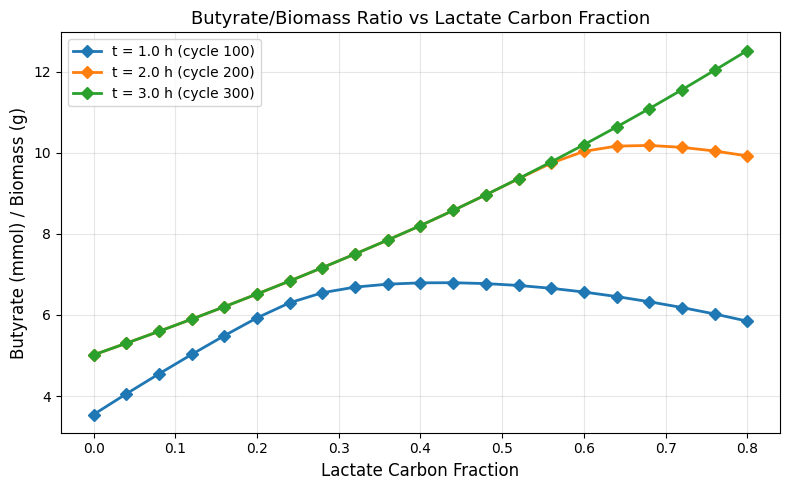

In [13]:
# Butyrate/biomass ratio vs lactate carbon fraction
lacC_frac_list = []
ratio_at_cycle = {cyc: [] for cyc in cycles}

for (glc_mM, lac_mM), sim in sorted(simulations.items()):
    media = sim.get_metabolite_time_series()

    # x-axis: lactate carbon fraction (0 to 1)
    denomC = 6 * glc_mM + 3 * lac_mM
    lacC_frac = (3 * lac_mM / denomC) if denomC > 0 else np.nan
    lacC_frac_list.append(lacC_frac)

    # time series
    #but_series = media['but[e]'].values / BOX_VOL_L if 'but[e]' in media.columns else None
    but_series = media['but[e]'].values if 'but[e]' in media.columns else None
    b_series = sim.total_biomass['Eubacterium'].values

    # y-axis: butyrate(mM) / biomass(g) at selected cycles
    for cyc in cycles:
        if (but_series is None or cyc >= len(but_series)
                or cyc >= len(b_series) or b_series[cyc] == 0):
            ratio_at_cycle[cyc].append(np.nan)
        else:
            ratio_at_cycle[cyc].append(but_series[cyc] / b_series[cyc])

plt.figure(figsize=(8, 5))
for cyc in cycles:
    t_hr = cyc * TIME_STEP
    plt.plot(lacC_frac_list, ratio_at_cycle[cyc], 'D-', linewidth=2,
             label=f't = {t_hr:.1f} h (cycle {cyc})')

plt.xlabel('Lactate Carbon Fraction', fontsize=12)
plt.ylabel('Butyrate (mmol) / Biomass (g)', fontsize=12)
plt.title('Butyrate/Biomass Ratio vs Lactate Carbon Fraction',
          fontsize=13)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()